# 1. Setup and Dataset Loading

### 1.1 Install and Import Libraries


In [1]:
# Install Required Libraries
!pip install nltk tqdm

# Import Standard Libraries
import os
import string
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from PIL import Image

# Import NLP Tools
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import corpus_bleu

# PyTorch & TorchVision Imports
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Progress Bar Utility (compatible with scripts, VS Code, and Colab)
from tqdm import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 1.2 Load Dataset from Google Drive


In [2]:
# Mount Google Drive to Access Dataset Files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.3 Set Dataset Paths and Validate Content


In [3]:
# Unzip the Flickr8k image and caption datasets
!unzip -o "/content/drive/MyDrive/Datasets/Flickr8k_Dataset.zip" -d "/content/"
!unzip -o "/content/drive/MyDrive/Datasets/Flickr8k_text.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/__MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: /content/Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: /content/__MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: /content/Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: /content/__MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: /content/Flicker8k_Dataset/3429641260_2f035c1813.jpg  
  inflating: /content/__MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: /content/Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: /content/__MACOSX/Flicker8k_Dataset/._3429956016_3c7e3096c2.jpg  
  inflating: /content/Flicker8k_Dataset/3430100177_5864bf1e73.jpg  
  inflating: /content/__MACOSX/Flicker8k_Dataset/._3430100177_5864bf1e73.jpg  
  inflating: /content/Flicker8k_Dataset/3430287726_94a1825bbf.jpg  
  inflating: /content/__MACOSX/Flicker8k_Dataset/._3430287726_94a18

### 1.4 Preview Caption File


In [4]:
# Define the image directory path
image_dir = "/content/Flicker8k_Dataset"

# Display number of images in the dataset
print("Total images:", len(os.listdir(image_dir)))

# Preview the first few lines of the caption file
!head /content/Flickr8k.token.txt

Total images: 8091
1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .


# 2. Caption Preprocessing

### 2.1 Clean and Preprocess Captions


In [5]:
# Load and clean captions from the Flickr8k token file
# - Removes punctuation
# - Converts text to lowercase
# - Adds special tokens <start> and <end> to each caption
# - Groups captions by image ID

def load_clean_captions(filepath):
    captions = defaultdict(list)
    table = str.maketrans('', '', string.punctuation)  # Translation table to remove punctuation

    with open(filepath, 'r') as file:
        for line in file:
            img_id, caption = line.strip().split('\t')  # Split on tab character
            img_id = img_id.split('#')[0]               # Extract image filename without caption index
            caption = caption.lower().translate(table)  # Lowercase and remove punctuation
            captions[img_id].append(f"<start> {caption} <end>")  # Add special tokens

    return captions

captions_dict = load_clean_captions("/content/Flickr8k.token.txt")

### 2.2 Build Vocabulary


In [6]:
# Build vocabulary from tokenized captions
# - Counts all word occurrences across all captions
# - Filters out rare words that appear less than the threshold (default = 5)
# - Creates vocabulary with special tokens: <pad>, <unk>
# - Generates mapping dictionaries: word2idx and idx2word

# Flatten all tokens from all captions into a single list
all_tokens = [word for captions in captions_dict.values() for cap in captions for word in cap.split()]

# Count frequency of each word
word_counts = Counter(all_tokens)
print(f"Total unique words before filtering: {len(word_counts)}")

# Filter out rare words and add special tokens
threshold = 5
vocab = ['<pad>', '<unk>'] + [w for w in word_counts if word_counts[w] >= threshold]

# Create lookup dictionaries
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(word2idx)

# Print vocabulary stats
print("Vocabulary Size:", vocab_size)
print("Example:", list(word2idx.items())[:10])

Total unique words before filtering: 8830
Vocabulary Size: 2995
Example: [('<pad>', 0), ('<unk>', 1), ('<start>', 2), ('a', 3), ('child', 4), ('in', 5), ('pink', 6), ('dress', 7), ('is', 8), ('climbing', 9)]


### 2.3 Encode Captions


In [7]:
# Convert cleaned captions to numerical format (token indices)
# - For each caption, replace words with corresponding indices from word2idx
# - Unknown words are replaced with the <unk> index
# - Returns a dictionary mapping each image ID to its list of encoded captions

def encode_captions(captions_dict, word2idx):
    encoded = {}
    for img_id, captions in captions_dict.items():
        img_id = img_id.replace(".jpg", "")  # ensure consistency in image ID formatting
        encoded_captions = []
        for caption in captions:
            tokens = caption.split()
            encoded_seq = [word2idx.get(word, word2idx['<unk>']) for word in tokens]
            encoded_captions.append(encoded_seq)
        encoded[img_id] = encoded_captions
    return encoded

# Generate encoded caption dictionary
encoded_captions = encode_captions(captions_dict, word2idx)

### 2.4 Pad and Inspect Caption Sequences


In [8]:
# Flatten all encoded captions into a single list
# - Each caption is converted to a PyTorch tensor
# - Captions are padded to the same length using <pad> token
# - This is useful for inspecting max length and batch preparation

# Combine all encoded captions from all images into one list
all_sequences = [cap for caps in encoded_captions.values() for cap in caps]

# Convert each caption sequence to a PyTorch tensor
tensor_sequences = [torch.tensor(seq) for seq in all_sequences]

# Determine the maximum caption length (useful for LSTM padding and truncation)
max_len = max(len(seq) for seq in tensor_sequences)
print("Max caption length:", max_len)

# Pad all sequences to the same length for consistent input shape
padded_seqs = pad_sequence(tensor_sequences, batch_first=True, padding_value=word2idx['<pad>'])

# Show padded tensor dimensions and a sample
print("Padded shape:", padded_seqs.shape)
print("Example padded sequence:", padded_seqs[0])

Max caption length: 38
Padded shape: torch.Size([40460, 38])
Example padded sequence: tensor([ 2,  3,  4,  5,  3,  6,  7,  8,  9, 10,  3, 11, 12, 13,  5, 14,  1, 15,
        16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0])


# 3. Image Preprocessing


### 3.1 Define Image Transformation Pipeline


In [9]:
# Define preprocessing pipeline for input images.
# This ensures consistency with ImageNet-pretrained CNNs like VGG16 and ResNet.

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224 pixels (expected input size for most CNNs)
    transforms.ToTensor(),          # Convert PIL Image to PyTorch Tensor (scales pixels to [0, 1])
    transforms.Normalize(           # Normalize using ImageNet means and stds for each channel
        mean=[0.485, 0.456, 0.406], # Mean values for R, G, B channels
        std=[0.229, 0.224, 0.225]   # Standard deviation for R, G, B channels
    )
])

### 3.2 Load and Modify Pretrained VGG16


In [10]:
# Load pretrained VGG16 model and remove the final classification layer.
# This turns VGG16 into a fixed feature extractor that outputs a 4096-dim feature vector per image.

vgg = models.vgg16(pretrained=True)  # Load VGG16 pretrained on ImageNet
vgg.classifier = nn.Sequential(*list(vgg.classifier.children())[:-1])  # Remove final classification layer
vgg = vgg.eval().cuda()  # Set to evaluation mode and move to GPU (if available)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 187MB/s]


### 3.3 Define RawImageCaptionDataset (for ResNet training)


In [11]:
class RawImageCaptionDataset(Dataset):
    """
    Custom PyTorch Dataset to load raw images and their corresponding encoded captions.
    Each image is loaded, transformed, and paired with one randomly selected caption.
    """

    def __init__(self, image_dir, encoded_captions, transform):
        """
        Args:
            image_dir (str): Directory containing image files.
            encoded_captions (dict): Dictionary mapping image IDs to lists of tokenized captions.
            transform (callable): Transformations to apply to each image (e.g., resizing, normalization).
        """
        self.image_dir = image_dir
        self.captions_dict = list(encoded_captions.items())
        self.transform = transform

    def __len__(self):
        # Return total number of unique image-caption pairs
        return len(self.captions_dict)

    def __getitem__(self, idx):
        # Get image ID and its associated captions
        img_id, captions = self.captions_dict[idx]
        img_path = os.path.join(self.image_dir, img_id + ".jpg")

        # Load and transform the image
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        # Randomly choose one caption from the list and prepare input/target sequences
        caption = random.choice(captions)
        input_seq = caption[:-1]   # All tokens except <end>
        target_seq = caption[1:]   # All tokens except <start>

        return image, torch.tensor(input_seq), torch.tensor(target_seq)

### 3.4 Extract Image Features Using VGG16


In [12]:
def extract_features_vgg(image_folder, model, transform):
    """
    Extracts CNN features from images using a pre-trained VGG16 model.

    Args:
        image_folder (str): Path to the directory containing image files.
        model (torch.nn.Module): Pre-trained VGG16 model without the classification head.
        transform (torchvision.transforms.Compose): Transformations to apply to each image.

    Returns:
        dict: A dictionary mapping image IDs (without extension) to their feature vectors.
    """
    features = {}

    for img_name in tqdm(os.listdir(image_folder)):
        img_path = os.path.join(image_folder, img_name)

        try:
            # Load and preprocess the image
            image = Image.open(img_path).convert("RGB")
            image = transform(image).unsqueeze(0).cuda()  # Add batch dimension

            # Extract features without computing gradients
            with torch.no_grad():
                feature = model(image)  # Output shape: [1, 4096]

            img_id = img_name.split('.')[0]
            features[img_id] = feature.squeeze(0).cpu()  # Remove batch dim and move to CPU

        except Exception as e:
            print(f"Error processing {img_name}: {e}")

    return features

# Extract VGG16 features for all images
image_features = extract_features_vgg(image_dir, vgg, transform)

# Optional: Save extracted features for later use
# torch.save(image_features, "flickr8k_vgg16_features.pth")

100%|██████████| 8091/8091 [00:58<00:00, 139.34it/s]


### 3.5 Define ResNet-50 Encoder for Attention-Based Model


In [13]:
class ResNetEncoder(nn.Module):
    """
    Encoder module using a pre-trained ResNet-50 backbone.

    This encoder extracts spatial features from an input image.
    It removes the final pooling and fully connected layers to retain
    the spatial map and outputs a reshaped tensor suitable for attention-based decoders.

    Output shape: [batch_size, 49, 2048]
    """

    def __init__(self):
        super(ResNetEncoder, self).__init__()

        # Load pre-trained ResNet-50 model
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # Remove average pooling and fully connected layers
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])

    def forward(self, images):
        """
        Args:
            images (Tensor): Batch of input images with shape [B, 3, 224, 224]

        Returns:
            Tensor: ResNet feature maps reshaped to [B, 49, 2048]
        """
        with torch.no_grad():
            features = self.resnet(images)  # Output shape: [B, 2048, 7, 7]

        # Rearrange dimensions to [B, 7, 7, 2048]
        features = features.permute(0, 2, 3, 1)

        # Flatten spatial dimensions: [B, 49, 2048]
        return features.view(features.size(0), -1, features.size(-1))

# 4. Dataset & Dataloader Setup

### 4.1 Load Train/Validation/Test Image Splits


In [14]:
# Utility function to load image IDs (without .jpg extension) from a split file
def load_image_ids(filepath):
    """
    Reads image filenames from a split file and returns a set of image IDs
    (filenames without the '.jpg' extension).

    Args:
        filepath (str): Path to the split file (train/test/val)

    Returns:
        Set[str]: A set of image IDs
    """
    with open(filepath, 'r') as file:
        return set(line.strip().split('.')[0] for line in file)

# Load the train, validation, and test image IDs
train_ids = load_image_ids('/content/Flickr_8k.trainImages.txt')
test_ids  = load_image_ids('/content/Flickr_8k.testImages.txt')
val_ids   = load_image_ids('/content/Flickr_8k.devImages.txt')

# Display split statistics
print(f"Train: {len(train_ids)} | Test: {len(test_ids)} | Val: {len(val_ids)}")

Train: 6000 | Test: 1000 | Val: 1000


### 4.2 Filter Captions and Features by Split


In [15]:
# Filter the encoded captions and extracted features based on the dataset splits

# Select captions corresponding to training, validation, and test image IDs
train_captions = {k: v for k, v in encoded_captions.items() if k in train_ids}
val_captions   = {k: v for k, v in encoded_captions.items() if k in val_ids}
test_captions  = {k: v for k, v in encoded_captions.items() if k in test_ids}

# Select pre-extracted VGG image features corresponding to each split
train_features = {k: v for k, v in image_features.items() if k in train_ids}
val_features   = {k: v for k, v in image_features.items() if k in val_ids}
test_features  = {k: v for k, v in image_features.items() if k in test_ids}

# Show count of captions and features per split
print(f"Train: {len(train_captions)} captions | {len(train_features)} features")
print(f"Val:   {len(val_captions)} captions | {len(val_features)} features")
print(f"Test:  {len(test_captions)} captions | {len(test_features)} features")

Train: 6000 captions | 6000 features
Val:   1000 captions | 1000 features
Test:  1000 captions | 1000 features


### 4.3 ImageCaptionDataset (for VGG Features)


In [16]:
class ImageCaptionDataset(Dataset):
    """
    Custom PyTorch Dataset for image captioning using pre-extracted image features.

    Each sample contains:
    - image feature vector
    - input caption sequence (excluding <end>)
    - target caption sequence (excluding <start>)
    """
    def __init__(self, image_features, encoded_captions):
        self.image_ids = []
        self.features = []
        self.input_seqs = []
        self.target_seqs = []

        for img_id, captions in encoded_captions.items():
            if img_id not in image_features:
                continue  # Skip if feature not available for image

            for caption in captions:
                input_seq = caption[:-1]   # Input to model (without <end>)
                target_seq = caption[1:]   # Expected output (without <start>)

                self.image_ids.append(img_id)
                self.features.append(image_features[img_id])
                self.input_seqs.append(torch.tensor(input_seq))
                self.target_seqs.append(torch.tensor(target_seq))

    def __len__(self):
        return len(self.input_seqs)

    def __getitem__(self, idx):
        """
        Returns:
            feature: tensor of shape [4096]
            input_seq: tensor of word indices (input to model)
            target_seq: tensor of word indices (expected output)
        """
        return self.features[idx], self.input_seqs[idx], self.target_seqs[idx]

### 4.4 Custom Collate Function


In [17]:
def collate_fn(batch):
    """
    Custom collate function to pad sequences and stack features into a batch.

    Args:
        batch: A list of tuples (feature, input_seq, target_seq)

    Returns:
        features: Tensor of shape [batch_size, feature_dim]
        input_seqs: Padded input sequences [batch_size, seq_len]
        target_seqs: Padded target sequences [batch_size, seq_len]
    """
    # Unpack individual elements from batch
    features, input_seqs, target_seqs = zip(*batch)

    # Stack feature vectors into a single tensor (shape: [batch_size, feature_dim])
    features = torch.stack(features)

    # Pad input and target sequences to the same length across the batch
    input_seqs = pad_sequence(input_seqs, batch_first=True, padding_value=word2idx['<pad>'])
    target_seqs = pad_sequence(target_seqs, batch_first=True, padding_value=word2idx['<pad>'])

    return features, input_seqs, target_seqs

### 4.5 Create DataLoaders for VGG-based Model


In [18]:
# Create datasets for training and validation using pre-extracted image features and encoded captions
train_dataset = ImageCaptionDataset(train_features, train_captions)
val_dataset = ImageCaptionDataset(val_features, val_captions)

# Wrap datasets with DataLoader to enable mini-batch loading and shuffling (for training)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Print the number of batches to confirm dataset size and batching
print(f"Train batches: {len(train_loader)} | Validation batches: {len(val_loader)}")

Train batches: 469 | Validation batches: 79


### 4.6 Create DataLoaders for ResNet + Attention Model


In [19]:
# Create DataLoader for ResNet training (uses raw images, not pre-extracted features)

# Initialize dataset objects with raw image paths and encoded captions
resnet_train_dataset = RawImageCaptionDataset(image_dir, train_captions, transform)
resnet_val_dataset   = RawImageCaptionDataset(image_dir, val_captions, transform)

# Construct DataLoader with padding-aware collate function
# - Batches images with randomly selected captions
# - Shuffles only training data for better learning
resnet_train_loader = DataLoader(resnet_train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
resnet_val_loader   = DataLoader(resnet_val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# 5. Model Architectures


### 5.1 Baseline CNN + LSTM Model


In [20]:
# Define the CNN + LSTM baseline model for image captioning
# - Takes VGG16 image features (4096-d) and caption tokens as input
# - Projects image features into embedding space
# - Uses LSTM to generate sequence outputs
# - Outputs vocabulary-sized logits at each time step

class CNNLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, feature_size=4096):
        super(CNNLSTMModel, self).__init__()

        # Project image feature vector into the same dimension as embeddings
        self.img_fc = nn.Linear(feature_size, embed_size)

        # Embedding layer to convert word indices into dense vectors
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # LSTM network for processing sequences
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)

        # Final linear layer to project hidden states to vocabulary scores
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, image_features, captions):
        # Project and expand image feature to match caption sequence format
        img_embed = self.img_fc(image_features).unsqueeze(1)

        # Embed caption tokens
        caption_embed = self.embedding(captions)

        # Concatenate image embedding with embedded captions
        inputs = torch.cat((img_embed, caption_embed), dim=1)

        # Feed sequence through LSTM
        lstm_out, _ = self.lstm(inputs)

        # Predict next word at each time step
        outputs = self.fc_out(lstm_out)

        return outputs

### 5.2 Attention-Based Decoder with ResNet Encoder


In [21]:
# Define the Attention mechanism
# - Computes attention weights based on image features and current hidden state
# - Produces context vector as the weighted sum of image features

class Attention(nn.Module):
    def __init__(self, feature_dim, hidden_dim, attn_dim):
        super(Attention, self).__init__()

        # Linear layers to project features and hidden state to attention space
        self.feature_fc = nn.Linear(feature_dim, attn_dim)
        self.hidden_fc = nn.Linear(hidden_dim, attn_dim)
        self.full_attn = nn.Linear(attn_dim, 1)

    def forward(self, features, hidden):
        # Project image features and hidden state
        attn1 = self.feature_fc(features)           # [B, 49, attn_dim]
        attn2 = self.hidden_fc(hidden).unsqueeze(1) # [B, 1, attn_dim]

        # Combine and apply non-linearity
        attn = torch.tanh(attn1 + attn2)            # [B, 49, attn_dim]

        # Compute attention scores and normalize
        score = self.full_attn(attn).squeeze(2)     # [B, 49]
        alpha = torch.softmax(score, dim=1)         # [B, 49]

        # Compute context vector as weighted sum of features
        context = (features * alpha.unsqueeze(2)).sum(dim=1)  # [B, feature_dim]

        return context, alpha

# Define the Decoder with Attention
# - Uses the context vector from attention + current word embedding as input
# - Feeds this to an LSTMCell to generate hidden states step-by-step
# - Outputs vocabulary logits at each time step

class DecoderWithAttention(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, feature_dim=2048, attn_dim=256):
        super(DecoderWithAttention, self).__init__()

        # Attention module
        self.attention = Attention(feature_dim, hidden_size, attn_dim)

        # Embedding layer for word indices
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # LSTMCell takes (embedding + context) at each step
        self.lstm = nn.LSTMCell(embed_size + feature_dim, hidden_size)

        # Output layer to project hidden state to vocab logits
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        # Embed the captions
        embeddings = self.embedding(captions)  # [B, T, embed_size]
        batch_size, seq_len, _ = embeddings.shape

        # Initialize hidden and cell states
        h = torch.zeros(batch_size, 512).to(device)
        c = torch.zeros(batch_size, 512).to(device)

        outputs = []

        for t in range(seq_len):
            # Compute attention-based context vector
            context, _ = self.attention(features, h)

            # Concatenate word embedding and context vector
            lstm_input = torch.cat((embeddings[:, t], context), dim=1)

            # Update hidden and cell state
            h, c = self.lstm(lstm_input, (h, c))

            # Compute output scores for the vocabulary
            output = self.fc(h)
            outputs.append(output)

        # Stack outputs across all time steps
        return torch.stack(outputs, dim=1)  # [B, T, vocab_size]

# 6. Training

### 6.1 Training Function for CNN-LSTM Baseline


In [22]:
# Define training loop for CNN-LSTM baseline model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    best_val_loss = float('inf')  # Track best validation loss to save model

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        # Iterate over training batches
        for features, input_seqs, target_seqs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            # Move data to device
            features, input_seqs, target_seqs = features.to(device), input_seqs.to(device), target_seqs.to(device)

            # Forward pass
            outputs = model(features, input_seqs)

            # Align prediction and target dimensions for loss computation
            outputs = outputs[:, 1:, :].reshape(-1, vocab_size)
            target_seqs = target_seqs.reshape(-1)

            # Compute loss and backpropagate
            loss = criterion(outputs, target_seqs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Compute average training loss for the epoch
        avg_train_loss = total_loss / len(train_loader)

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, input_seqs, target_seqs in val_loader:
                features, input_seqs, target_seqs = features.to(device), input_seqs.to(device), target_seqs.to(device)
                outputs = model(features, input_seqs)
                outputs = outputs[:, 1:, :].reshape(-1, vocab_size)
                target_seqs = target_seqs.reshape(-1)
                loss = criterion(outputs, target_seqs)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f}")

        # Save the model if it has the best validation loss so far
        if avg_val_loss < best_val_loss or epoch == 0:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Best model saved.")

### 6.2 Training Function for ResNet + Attention Model


In [23]:
# Train the encoder-decoder model with attention using raw image inputs
def train_model_attention(encoder, decoder, train_loader, val_loader, criterion, encoder_optimizer, decoder_optimizer, epochs=10):
    best_val_loss = float('inf')  # Track best validation loss

    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        total_loss = 0

        # Loop through training batches
        for images, input_seqs, target_seqs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            # Move data to device
            images, input_seqs, target_seqs = images.to(device), input_seqs.to(device), target_seqs.to(device)

            # Zero gradients
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            # Forward pass through encoder and decoder
            features = encoder(images)
            outputs = decoder(features, input_seqs)

            # Truncate sequences to the shortest length to match shapes
            min_len = min(outputs.size(1), target_seqs.size(1))
            outputs = outputs[:, :min_len, :].reshape(-1, outputs.size(-1))
            target_seqs = target_seqs[:, :min_len].reshape(-1)

            # Compute loss and update model weights
            loss = criterion(outputs, target_seqs)
            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Evaluate on validation set
        encoder.eval()
        decoder.eval()
        val_loss = 0

        with torch.no_grad():
            for images, input_seqs, target_seqs in val_loader:
                images, input_seqs, target_seqs = images.to(device), input_seqs.to(device), target_seqs.to(device)

                features = encoder(images)
                outputs = decoder(features, input_seqs)

                # Truncate and flatten for loss calculation
                min_len = min(outputs.size(1), target_seqs.size(1))
                outputs = outputs[:, :min_len, :].reshape(-1, outputs.size(-1))
                target_seqs = target_seqs[:, :min_len].reshape(-1)

                loss = criterion(outputs, target_seqs)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f}")

        # Save the best model based on validation loss
        if avg_val_loss < best_val_loss or epoch == 0:
            best_val_loss = avg_val_loss
            torch.save({
                'encoder': encoder.state_dict(),
                'decoder': decoder.state_dict()
            }, "best_model_attention.pth")
            print("✅ Best model saved.")

### 6.3 Initialize Baseline CNN-LSTM Model


In [24]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model hyperparameters
vocab_size = len(word2idx)  # Total vocabulary size
embed_size = 256            # Dimension of word embeddings
hidden_size = 512           # Number of hidden units in LSTM

# Initialize the baseline CNN-LSTM model
model = CNNLSTMModel(vocab_size, embed_size, hidden_size).to(device)

# Set loss function, ignoring padding tokens during training
pad_idx = word2idx['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

# Use Adam optimizer for training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### 6.4 Train Baseline Model (VGG + LSTM)


In [25]:
# Train the baseline CNN-LSTM model using VGG16 features
# - Trains for 50 epochs using the best_model.pth saving strategy
# - Uses padded caption sequences and pre-extracted VGG image features
train_model(
    model,                    # The CNN-LSTM model (VGG-based)
    train_loader,            # DataLoader with VGG16 features for training
    val_loader,              # DataLoader with VGG16 features for validation
    criterion,               # CrossEntropyLoss (ignoring <pad> tokens)
    optimizer,               # Adam optimizer for the baseline model
    epochs=50                # Total number of training epochs
)

Epoch 1/50: 100%|██████████| 469/469 [00:02<00:00, 166.99it/s]


Epoch 1: Train Loss = 3.7984 | Val Loss = 3.3215
✅ Best model saved.


Epoch 2/50: 100%|██████████| 469/469 [00:02<00:00, 209.04it/s]


Epoch 2: Train Loss = 3.0300 | Val Loss = 3.0574
✅ Best model saved.


Epoch 3/50: 100%|██████████| 469/469 [00:02<00:00, 209.72it/s]


Epoch 3: Train Loss = 2.7476 | Val Loss = 2.9535
✅ Best model saved.


Epoch 4/50: 100%|██████████| 469/469 [00:02<00:00, 211.04it/s]


Epoch 4: Train Loss = 2.5514 | Val Loss = 2.9090
✅ Best model saved.


Epoch 5/50: 100%|██████████| 469/469 [00:02<00:00, 202.87it/s]


Epoch 5: Train Loss = 2.3879 | Val Loss = 2.8918
✅ Best model saved.


Epoch 6/50: 100%|██████████| 469/469 [00:02<00:00, 203.56it/s]


Epoch 6: Train Loss = 2.2370 | Val Loss = 2.8905
✅ Best model saved.


Epoch 7/50: 100%|██████████| 469/469 [00:02<00:00, 204.75it/s]


Epoch 7: Train Loss = 2.0973 | Val Loss = 2.9107


Epoch 8/50: 100%|██████████| 469/469 [00:02<00:00, 210.54it/s]


Epoch 8: Train Loss = 1.9638 | Val Loss = 2.9368


Epoch 9/50: 100%|██████████| 469/469 [00:02<00:00, 210.69it/s]


Epoch 9: Train Loss = 1.8345 | Val Loss = 2.9768


Epoch 10/50: 100%|██████████| 469/469 [00:02<00:00, 210.26it/s]


Epoch 10: Train Loss = 1.7152 | Val Loss = 3.0308


Epoch 11/50: 100%|██████████| 469/469 [00:02<00:00, 208.69it/s]


Epoch 11: Train Loss = 1.6033 | Val Loss = 3.0823


Epoch 12/50: 100%|██████████| 469/469 [00:02<00:00, 208.19it/s]


Epoch 12: Train Loss = 1.4965 | Val Loss = 3.1376


Epoch 13/50: 100%|██████████| 469/469 [00:02<00:00, 211.79it/s]


Epoch 13: Train Loss = 1.3973 | Val Loss = 3.1982


Epoch 14/50: 100%|██████████| 469/469 [00:02<00:00, 210.84it/s]


Epoch 14: Train Loss = 1.3084 | Val Loss = 3.2614


Epoch 15/50: 100%|██████████| 469/469 [00:02<00:00, 210.63it/s]


Epoch 15: Train Loss = 1.2249 | Val Loss = 3.3298


Epoch 16/50: 100%|██████████| 469/469 [00:02<00:00, 208.69it/s]


Epoch 16: Train Loss = 1.1515 | Val Loss = 3.4039


Epoch 17/50: 100%|██████████| 469/469 [00:02<00:00, 206.06it/s]


Epoch 17: Train Loss = 1.0796 | Val Loss = 3.4756


Epoch 18/50: 100%|██████████| 469/469 [00:02<00:00, 209.03it/s]


Epoch 18: Train Loss = 1.0186 | Val Loss = 3.5378


Epoch 19/50: 100%|██████████| 469/469 [00:02<00:00, 210.82it/s]


Epoch 19: Train Loss = 0.9632 | Val Loss = 3.6132


Epoch 20/50: 100%|██████████| 469/469 [00:02<00:00, 211.47it/s]


Epoch 20: Train Loss = 0.9123 | Val Loss = 3.6833


Epoch 21/50: 100%|██████████| 469/469 [00:02<00:00, 211.73it/s]


Epoch 21: Train Loss = 0.8680 | Val Loss = 3.7581


Epoch 22/50: 100%|██████████| 469/469 [00:02<00:00, 207.11it/s]


Epoch 22: Train Loss = 0.8252 | Val Loss = 3.8203


Epoch 23/50: 100%|██████████| 469/469 [00:02<00:00, 212.00it/s]


Epoch 23: Train Loss = 0.7887 | Val Loss = 3.8943


Epoch 24/50: 100%|██████████| 469/469 [00:02<00:00, 212.57it/s]


Epoch 24: Train Loss = 0.7545 | Val Loss = 3.9606


Epoch 25/50: 100%|██████████| 469/469 [00:02<00:00, 211.17it/s]


Epoch 25: Train Loss = 0.7230 | Val Loss = 4.0220


Epoch 26/50: 100%|██████████| 469/469 [00:02<00:00, 210.66it/s]


Epoch 26: Train Loss = 0.6964 | Val Loss = 4.1042


Epoch 27/50: 100%|██████████| 469/469 [00:02<00:00, 206.94it/s]


Epoch 27: Train Loss = 0.6695 | Val Loss = 4.1757


Epoch 28/50: 100%|██████████| 469/469 [00:02<00:00, 211.76it/s]


Epoch 28: Train Loss = 0.6493 | Val Loss = 4.2190


Epoch 29/50: 100%|██████████| 469/469 [00:02<00:00, 210.83it/s]


Epoch 29: Train Loss = 0.6252 | Val Loss = 4.2989


Epoch 30/50: 100%|██████████| 469/469 [00:02<00:00, 210.47it/s]


Epoch 30: Train Loss = 0.6064 | Val Loss = 4.3543


Epoch 31/50: 100%|██████████| 469/469 [00:02<00:00, 212.43it/s]


Epoch 31: Train Loss = 0.5883 | Val Loss = 4.4072


Epoch 32/50: 100%|██████████| 469/469 [00:02<00:00, 204.37it/s]


Epoch 32: Train Loss = 0.5752 | Val Loss = 4.4532


Epoch 33/50: 100%|██████████| 469/469 [00:02<00:00, 210.95it/s]


Epoch 33: Train Loss = 0.5617 | Val Loss = 4.5230


Epoch 34/50: 100%|██████████| 469/469 [00:02<00:00, 209.78it/s]


Epoch 34: Train Loss = 0.5484 | Val Loss = 4.5718


Epoch 35/50: 100%|██████████| 469/469 [00:02<00:00, 211.77it/s]


Epoch 35: Train Loss = 0.5351 | Val Loss = 4.6142


Epoch 36/50: 100%|██████████| 469/469 [00:02<00:00, 211.08it/s]


Epoch 36: Train Loss = 0.5238 | Val Loss = 4.6751


Epoch 37/50: 100%|██████████| 469/469 [00:02<00:00, 209.20it/s]


Epoch 37: Train Loss = 0.5133 | Val Loss = 4.7321


Epoch 38/50: 100%|██████████| 469/469 [00:02<00:00, 211.66it/s]


Epoch 38: Train Loss = 0.5085 | Val Loss = 4.7746


Epoch 39/50: 100%|██████████| 469/469 [00:02<00:00, 213.10it/s]


Epoch 39: Train Loss = 0.4965 | Val Loss = 4.8003


Epoch 40/50: 100%|██████████| 469/469 [00:02<00:00, 211.26it/s]


Epoch 40: Train Loss = 0.4877 | Val Loss = 4.8840


Epoch 41/50: 100%|██████████| 469/469 [00:02<00:00, 211.36it/s]


Epoch 41: Train Loss = 0.4810 | Val Loss = 4.9126


Epoch 42/50: 100%|██████████| 469/469 [00:02<00:00, 209.15it/s]


Epoch 42: Train Loss = 0.4717 | Val Loss = 4.9568


Epoch 43/50: 100%|██████████| 469/469 [00:02<00:00, 209.05it/s]


Epoch 43: Train Loss = 0.4668 | Val Loss = 4.9882


Epoch 44/50: 100%|██████████| 469/469 [00:02<00:00, 212.46it/s]


Epoch 44: Train Loss = 0.4614 | Val Loss = 5.0274


Epoch 45/50: 100%|██████████| 469/469 [00:02<00:00, 212.16it/s]


Epoch 45: Train Loss = 0.4574 | Val Loss = 5.0473


Epoch 46/50: 100%|██████████| 469/469 [00:02<00:00, 210.32it/s]


Epoch 46: Train Loss = 0.4500 | Val Loss = 5.1037


Epoch 47/50: 100%|██████████| 469/469 [00:02<00:00, 209.93it/s]


Epoch 47: Train Loss = 0.4473 | Val Loss = 5.1524


Epoch 48/50: 100%|██████████| 469/469 [00:02<00:00, 207.37it/s]


Epoch 48: Train Loss = 0.4417 | Val Loss = 5.1843


Epoch 49/50: 100%|██████████| 469/469 [00:02<00:00, 210.63it/s]


Epoch 49: Train Loss = 0.4381 | Val Loss = 5.1975


Epoch 50/50: 100%|██████████| 469/469 [00:02<00:00, 210.48it/s]


Epoch 50: Train Loss = 0.4349 | Val Loss = 5.2492


### 6.5 Load Best Baseline Model


In [26]:
# Load the best-performing baseline CNN-LSTM model
# - Loads weights from the best epoch (lowest validation loss)
# - Sets the model to evaluation mode (disables dropout, etc.)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

CNNLSTMModel(
  (img_fc): Linear(in_features=4096, out_features=256, bias=True)
  (embedding): Embedding(2995, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (fc_out): Linear(in_features=512, out_features=2995, bias=True)
)

### 6.6 Initialize ResNet + Attention Model Components


In [27]:
# Initialize ResNet-based encoder and attention-based decoder
# - Encoder extracts spatial image features using pretrained ResNet-50
# - Decoder uses attention mechanism and LSTM to generate captions
encoder = ResNetEncoder().to(device)
decoder = DecoderWithAttention(embed_size=256, hidden_size=512, vocab_size=len(word2idx)).to(device)

# Define optimizers for both encoder and decoder
# - Encoder uses a smaller learning rate
# - Decoder uses a higher learning rate to learn more quickly
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-4)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=4e-4)

# Define loss function
# - Ignores <pad> tokens during loss computation
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<pad>'])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


### 6.7 Train ResNet + Attention Captioning Model


In [28]:
# Train the ResNet + Attention + LSTM model
# - Uses raw images instead of precomputed CNN features
# - Trains for 50 epochs using resnet_train_loader and resnet_val_loader
train_model_attention(
    encoder,                 # ResNet50-based encoder (outputs feature maps)
    decoder,                 # Attention-based LSTM decoder
    resnet_train_loader,     # DataLoader using raw images for training
    resnet_val_loader,       # DataLoader using raw images for validation
    criterion,               # CrossEntropyLoss (ignoring <pad> tokens)
    encoder_optimizer,       # Adam optimizer for the encoder
    decoder_optimizer,       # Adam optimizer for the decoder
    epochs=50                # Total number of training epochs
)

Epoch 1/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 1: Train Loss = 5.1738 | Val Loss = 4.5024
✅ Best model saved.


Epoch 2/50: 100%|██████████| 94/94 [00:36<00:00,  2.58it/s]


Epoch 2: Train Loss = 4.1729 | Val Loss = 4.0223
✅ Best model saved.


Epoch 3/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 3: Train Loss = 3.8043 | Val Loss = 3.7465
✅ Best model saved.


Epoch 4/50: 100%|██████████| 94/94 [00:36<00:00,  2.58it/s]


Epoch 4: Train Loss = 3.5622 | Val Loss = 3.5834
✅ Best model saved.


Epoch 5/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 5: Train Loss = 3.4156 | Val Loss = 3.4468
✅ Best model saved.


Epoch 6/50: 100%|██████████| 94/94 [00:36<00:00,  2.58it/s]


Epoch 6: Train Loss = 3.2770 | Val Loss = 3.3697
✅ Best model saved.


Epoch 7/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 7: Train Loss = 3.1535 | Val Loss = 3.3085
✅ Best model saved.


Epoch 8/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 8: Train Loss = 3.0586 | Val Loss = 3.2088
✅ Best model saved.


Epoch 9/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 9: Train Loss = 2.9800 | Val Loss = 3.2134


Epoch 10/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 10: Train Loss = 2.8997 | Val Loss = 3.1547
✅ Best model saved.


Epoch 11/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 11: Train Loss = 2.8497 | Val Loss = 3.1118
✅ Best model saved.


Epoch 12/50: 100%|██████████| 94/94 [00:36<00:00,  2.56it/s]


Epoch 12: Train Loss = 2.7646 | Val Loss = 3.0727
✅ Best model saved.


Epoch 13/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 13: Train Loss = 2.7194 | Val Loss = 3.0650
✅ Best model saved.


Epoch 14/50: 100%|██████████| 94/94 [00:36<00:00,  2.56it/s]


Epoch 14: Train Loss = 2.6456 | Val Loss = 3.0177
✅ Best model saved.


Epoch 15/50: 100%|██████████| 94/94 [00:36<00:00,  2.56it/s]


Epoch 15: Train Loss = 2.5956 | Val Loss = 3.0463


Epoch 16/50: 100%|██████████| 94/94 [00:36<00:00,  2.56it/s]


Epoch 16: Train Loss = 2.5536 | Val Loss = 2.9857
✅ Best model saved.


Epoch 17/50: 100%|██████████| 94/94 [00:36<00:00,  2.56it/s]


Epoch 17: Train Loss = 2.5012 | Val Loss = 2.9958


Epoch 18/50: 100%|██████████| 94/94 [00:36<00:00,  2.56it/s]


Epoch 18: Train Loss = 2.4745 | Val Loss = 2.9962


Epoch 19/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 19: Train Loss = 2.4157 | Val Loss = 2.9657
✅ Best model saved.


Epoch 20/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 20: Train Loss = 2.3544 | Val Loss = 2.9597
✅ Best model saved.


Epoch 21/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 21: Train Loss = 2.3359 | Val Loss = 2.9911


Epoch 22/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 22: Train Loss = 2.2802 | Val Loss = 2.9507
✅ Best model saved.


Epoch 23/50: 100%|██████████| 94/94 [00:36<00:00,  2.56it/s]


Epoch 23: Train Loss = 2.2659 | Val Loss = 2.9277
✅ Best model saved.


Epoch 24/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 24: Train Loss = 2.2119 | Val Loss = 2.9697


Epoch 25/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 25: Train Loss = 2.1875 | Val Loss = 2.9559


Epoch 26/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 26: Train Loss = 2.1433 | Val Loss = 2.9446


Epoch 27/50: 100%|██████████| 94/94 [00:36<00:00,  2.55it/s]


Epoch 27: Train Loss = 2.1218 | Val Loss = 2.9687


Epoch 28/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 28: Train Loss = 2.0973 | Val Loss = 2.9272
✅ Best model saved.


Epoch 29/50: 100%|██████████| 94/94 [00:36<00:00,  2.58it/s]


Epoch 29: Train Loss = 2.0454 | Val Loss = 2.9419


Epoch 30/50: 100%|██████████| 94/94 [00:36<00:00,  2.59it/s]


Epoch 30: Train Loss = 2.0221 | Val Loss = 2.9315


Epoch 31/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 31: Train Loss = 1.9707 | Val Loss = 2.9601


Epoch 32/50: 100%|██████████| 94/94 [00:36<00:00,  2.58it/s]


Epoch 32: Train Loss = 1.9676 | Val Loss = 2.9368


Epoch 33/50: 100%|██████████| 94/94 [00:36<00:00,  2.56it/s]


Epoch 33: Train Loss = 1.9483 | Val Loss = 2.9551


Epoch 34/50: 100%|██████████| 94/94 [00:36<00:00,  2.56it/s]


Epoch 34: Train Loss = 1.8930 | Val Loss = 2.9455


Epoch 35/50: 100%|██████████| 94/94 [00:36<00:00,  2.58it/s]


Epoch 35: Train Loss = 1.8810 | Val Loss = 2.9715


Epoch 36/50: 100%|██████████| 94/94 [00:36<00:00,  2.56it/s]


Epoch 36: Train Loss = 1.8573 | Val Loss = 2.9881


Epoch 37/50: 100%|██████████| 94/94 [00:36<00:00,  2.55it/s]


Epoch 37: Train Loss = 1.8289 | Val Loss = 3.0003


Epoch 38/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 38: Train Loss = 1.7963 | Val Loss = 2.9024
✅ Best model saved.


Epoch 39/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 39: Train Loss = 1.7680 | Val Loss = 2.9681


Epoch 40/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 40: Train Loss = 1.7444 | Val Loss = 2.9682


Epoch 41/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 41: Train Loss = 1.7337 | Val Loss = 2.9686


Epoch 42/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 42: Train Loss = 1.7089 | Val Loss = 2.9837


Epoch 43/50: 100%|██████████| 94/94 [00:36<00:00,  2.56it/s]


Epoch 43: Train Loss = 1.6817 | Val Loss = 3.0163


Epoch 44/50: 100%|██████████| 94/94 [00:36<00:00,  2.58it/s]


Epoch 44: Train Loss = 1.6628 | Val Loss = 2.9775


Epoch 45/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 45: Train Loss = 1.6407 | Val Loss = 2.9889


Epoch 46/50: 100%|██████████| 94/94 [00:36<00:00,  2.58it/s]


Epoch 46: Train Loss = 1.5976 | Val Loss = 2.9995


Epoch 47/50: 100%|██████████| 94/94 [00:36<00:00,  2.59it/s]


Epoch 47: Train Loss = 1.5911 | Val Loss = 2.9984


Epoch 48/50: 100%|██████████| 94/94 [00:36<00:00,  2.58it/s]


Epoch 48: Train Loss = 1.5766 | Val Loss = 3.0512


Epoch 49/50: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Epoch 49: Train Loss = 1.5537 | Val Loss = 3.0155


Epoch 50/50: 100%|██████████| 94/94 [00:36<00:00,  2.58it/s]


Epoch 50: Train Loss = 1.5201 | Val Loss = 3.0354


### 6.8 Load Best ResNet + Attention Model


In [29]:
# Load the best-performing ResNet + Attention + LSTM model
# - Loads encoder and decoder weights from the best epoch (lowest validation loss)
# - Sets both encoder and decoder to evaluation mode (disables dropout, etc.)
checkpoint = torch.load("best_model_attention.pth")

encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

encoder.eval()
decoder.eval()

DecoderWithAttention(
  (attention): Attention(
    (feature_fc): Linear(in_features=2048, out_features=256, bias=True)
    (hidden_fc): Linear(in_features=512, out_features=256, bias=True)
    (full_attn): Linear(in_features=256, out_features=1, bias=True)
  )
  (embedding): Embedding(2995, 256)
  (lstm): LSTMCell(2304, 512)
  (fc): Linear(in_features=512, out_features=2995, bias=True)
)

# 7. Caption Generation Functions


### 7.1 Greedy Decoding (VGG + LSTM)


In [30]:
def generate_caption(model, image_feature, word2idx, idx2word, max_len=30):
    """
    Generate a caption using greedy decoding.

    Args:
        model (nn.Module): Trained image captioning model.
        image_feature (Tensor): Feature vector for a single image.
        word2idx (dict): Mapping from word to index.
        idx2word (dict): Mapping from index to word.
        max_len (int): Maximum length of the generated caption.

    Returns:
        str: Generated caption as a single string.
    """
    model.eval()

    # Initialize caption with the <start> token
    caption = ['<start>']
    input_seq = [word2idx['<start>']]

    for _ in range(max_len):
        # Convert current input sequence to tensor
        inputs = torch.tensor(input_seq).unsqueeze(0).to(device)
        feature = image_feature.unsqueeze(0).to(device)

        # Forward pass through the model (no gradient needed)
        with torch.no_grad():
            outputs = model(feature, inputs)

        # Get the prediction for the next word
        next_token_logits = outputs[0, -1, :]
        next_token = torch.argmax(next_token_logits).item()
        next_word = idx2word.get(next_token, '<unk>')

        # Stop if <end> token is generated
        if next_word == '<end>':
            break

        # Append predicted word to the caption
        caption.append(next_word)
        input_seq.append(next_token)

    # Return generated caption excluding the <start> token
    return ' '.join(caption[1:])

### 7.2 Beam Search Decoding (VGG + LSTM)


In [31]:
def generate_caption_beam_search(model, image_feature, word2idx, idx2word, beam_width=3, max_len=30):
    """
    Generate a caption using beam search decoding.

    Args:
        model (nn.Module): Trained image captioning model.
        image_feature (Tensor): Feature vector for a single image.
        word2idx (dict): Mapping from word to index.
        idx2word (dict): Mapping from index to word.
        beam_width (int): Number of beams to keep during decoding.
        max_len (int): Maximum length of the generated caption.

    Returns:
        str: Best generated caption from beam search.
    """
    model.eval()

    # Define special token IDs
    start_token = word2idx['<start>']
    end_token = word2idx['<end>']

    # Initialize sequence with the start token
    sequences = [[ [start_token], 0.0 ]]  # Each entry is (sequence, cumulative log-probability)

    for _ in range(max_len):
        all_candidates = []

        # Iterate through current beam sequences
        for seq, score in sequences:
            if seq[-1] == end_token:
                all_candidates.append((seq, score))  # If already ended, keep as is
                continue

            # Prepare inputs
            inputs = torch.tensor(seq).unsqueeze(0).to(device)
            feature = image_feature.unsqueeze(0).to(device)

            # Forward pass
            with torch.no_grad():
                outputs = model(feature, inputs)

            # Compute log probabilities of next tokens
            next_token_logits = outputs[0, -1, :]
            probs = torch.log_softmax(next_token_logits, dim=0)

            # Get top-k tokens and scores
            top_tokens = torch.topk(probs, beam_width)

            # Create new candidate sequences
            for i in range(beam_width):
                token = top_tokens.indices[i].item()
                token_score = top_tokens.values[i].item()
                new_seq = seq + [token]
                new_score = score + token_score
                all_candidates.append((new_seq, new_score))

        # Keep only the best `beam_width` sequences
        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
        sequences = ordered[:beam_width]

    # Select the sequence with the highest score
    best_seq = sequences[0][0]

    # Convert token indices to words, filtering out special tokens
    caption = [
        idx2word[idx]
        for idx in best_seq
        if idx not in {start_token, end_token, word2idx['<pad>']}
    ]

    return ' '.join(caption)

### 7.3 Greedy Decoding with ResNet + Attention


In [32]:
def generate_caption_attention(encoder, decoder, image, word2idx, idx2word, max_len=30):
    """
    Generate a caption using a ResNet encoder and attention-based LSTM decoder.

    Args:
        encoder (nn.Module): CNN encoder (e.g., ResNet) for image features.
        decoder (nn.Module): Attention-based LSTM decoder.
        image (Tensor): Raw image tensor (already transformed).
        word2idx (dict): Mapping from words to token IDs.
        idx2word (dict): Mapping from token IDs to words.
        max_len (int): Maximum length of the caption to generate.

    Returns:
        str: Generated caption string.
    """
    # Set encoder and decoder to evaluation mode
    encoder.eval()
    decoder.eval()

    # Extract visual features from the image
    with torch.no_grad():
        features = encoder(image.unsqueeze(0).to(device))  # [1, 49, 2048]

    # Initialize the caption with the <start> token
    caption = [word2idx['<start>']]

    # Initialize LSTM hidden and cell states
    h = torch.zeros(1, 512).to(device)
    c = torch.zeros(1, 512).to(device)

    # Store generated words
    result = []

    for _ in range(max_len):
        # Prepare the current input word embedding
        input_word = torch.tensor([caption[-1]]).to(device)
        embedding = decoder.embedding(input_word)  # [1, embed_size]

        # Compute attention-weighted visual context
        context, _ = decoder.attention(features, h)  # [1, 2048]

        # Concatenate context and embedding, pass through LSTM
        lstm_input = torch.cat((embedding.view(1, -1), context), dim=1)
        h, c = decoder.lstm(lstm_input, (h, c))

        # Generate the next word token
        output = decoder.fc(h)  # [1, vocab_size]
        predicted = output.argmax(1).item()

        # Stop if <end> token is generated
        if predicted == word2idx['<end>']:
            break

        # Append the word and continue
        result.append(idx2word[predicted])
        caption.append(predicted)

    return ' '.join(result)

### 7.4 Beam Search Decoding with ResNet + Attention


In [33]:
def generate_caption_attention_beam_search(encoder, decoder, image, word2idx, idx2word, beam_width=3, max_len=30):
    """
    Generate an image caption using beam search with an attention-based encoder-decoder.

    Args:
        encoder (nn.Module): ResNet encoder model.
        decoder (nn.Module): Decoder with attention mechanism.
        image (Tensor): Transformed input image tensor.
        word2idx (dict): Mapping from words to token indices.
        idx2word (dict): Mapping from token indices to words.
        beam_width (int): Number of beams to maintain during decoding.
        max_len (int): Maximum length of the generated caption.

    Returns:
        str: Final generated caption string.
    """
    # Set models to evaluation mode
    encoder.eval()
    decoder.eval()

    start_token = word2idx['<start>']
    end_token = word2idx['<end>']

    # Extract features from the image using the encoder
    with torch.no_grad():
        features = encoder(image.unsqueeze(0).to(device))  # [1, 49, 2048]

    # Each sequence is [generated_tokens, last_token, total_score, hidden_state, cell_state]
    sequences = [[[], start_token, 0.0, torch.zeros(1, 512).to(device), torch.zeros(1, 512).to(device)]]
    completed_sequences = []

    for _ in range(max_len):
        all_candidates = []

        for seq, last_token, score, h, c in sequences:
            # If the last token is <end>, move the sequence to completed
            if last_token == end_token:
                completed_sequences.append((seq, score))
                continue

            # Embed the last generated token
            input_word = torch.tensor([last_token]).to(device)
            embedding = decoder.embedding(input_word)  # [1, embed_size]

            # Compute attention context vector
            context, _ = decoder.attention(features, h)

            # Concatenate embedding and context to pass into LSTM
            lstm_input = torch.cat((embedding, context), dim=1)
            h, c = decoder.lstm(lstm_input, (h, c))

            # Predict the next token probabilities
            output = decoder.fc(h)
            probs = torch.log_softmax(output, dim=1).squeeze(0)

            # Select top `beam_width` candidates
            top_k_probs, top_k_tokens = torch.topk(probs, beam_width)

            for i in range(beam_width):
                new_seq = seq + [top_k_tokens[i].item()]
                new_score = score + top_k_probs[i].item()
                all_candidates.append((new_seq, top_k_tokens[i].item(), new_score, h, c))

        # Keep only the top `beam_width` sequences
        sequences = sorted(all_candidates, key=lambda tup: tup[2], reverse=True)[:beam_width]

    # Select the best complete sequence (or fallback to the top unfinished one)
    best_seq = max(completed_sequences, key=lambda x: x[1])[0] if completed_sequences else sequences[0][0]

    # Convert token indices to words and remove special tokens
    caption = [idx2word[idx] for idx in best_seq if idx not in {start_token, end_token, word2idx['<pad>']}]
    return ' '.join(caption)

# 8. Evaluation


### 8.1 BLEU Score Evaluation Function


In [34]:
def evaluate_bleu(generate_fn, label="Greedy/Beam", model_type="VGG"):
    """
    Evaluate BLEU scores for generated captions using the specified generation function.

    Args:
        generate_fn (function): Caption generation function (greedy or beam search).
        label (str): Label for identifying decoding type in output.
        model_type (str): 'VGG' for baseline model or 'ResNet' for attention-based model.

    Returns:
        None. Prints BLEU-1 through BLEU-4 scores.
    """
    generated_captions = {}

    # Generate captions for each image in the test set
    for img_id in tqdm(test_features.keys(), desc=f"Generating ({label}) - {model_type}"):
        feature = test_features[img_id]

        if model_type == "ResNet":
            # For ResNet-based model, reload and transform the raw image
            img_path = os.path.join(image_dir, img_id + ".jpg")
            image = Image.open(img_path).convert("RGB")
            image_tensor = transform(image).to(device)
            caption = generate_fn(encoder, decoder, image_tensor, word2idx, idx2word)
        else:
            # For VGG-based model, use extracted image features directly
            caption = generate_fn(model, feature, word2idx, idx2word)

        generated_captions[img_id] = caption

    references, hypotheses = [], []

    # Prepare references and generated hypotheses for BLEU evaluation
    for img_id in test_captions:
        ref_captions = test_captions[img_id]

        # Remove <start> and <end> tokens from references
        refs = [cap[1:-1] for cap in ref_captions]
        refs = [[idx2word[idx] for idx in r if idx != word2idx['<pad>']] for r in refs]

        # Tokenize the generated caption
        gen = generated_captions[img_id].split()

        references.append(refs)
        hypotheses.append(gen)

    # Compute BLEU scores for unigrams to 4-grams
    bleu1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

    # Display BLEU scores
    print(f"\n🔎 BLEU Scores ({label} - {model_type}):")
    print(f"BLEU-1: {bleu1:.4f}")
    print(f"BLEU-2: {bleu2:.4f}")
    print(f"BLEU-3: {bleu3:.4f}")
    print(f"BLEU-4: {bleu4:.4f}")

### 8.2 Define Actual vs Predicted Captions Function


In [35]:
def show_actual_vs_predicted(img_id, image_dir, word2idx, idx2word, model_type="VGG", beam=False):
    """
    Display actual reference captions and predicted caption for a given image.

    Args:
        img_id (str): Image ID (without extension).
        image_dir (str): Path to the image folder.
        word2idx (dict): Vocabulary word-to-index mapping.
        idx2word (dict): Vocabulary index-to-word mapping.
        model_type (str): 'VGG' or 'ResNet' to select model type.
        beam (bool): If True, use beam search for prediction.

    Returns:
        None. Displays image and prints captions.
    """
    # Load the image file
    image_name = img_id + ".jpg"
    img_path = os.path.join(image_dir, image_name)
    image = Image.open(img_path).convert("RGB")

    # Show all ground truth captions for the selected image
    print("\n---------------------Actual---------------------")
    for cap in test_captions[img_id]:
        words = [idx2word[idx] for idx in cap[1:-1] if idx != word2idx['<pad>']]
        print("startseq", ' '.join(words), "endseq")

    # Generate a caption using the specified model and decoding method
    print("--------------------Predicted--------------------")
    if model_type == "ResNet":
        # Preprocess the raw image input for ResNet
        image_tensor = transform(image).to(device)
        if beam:
            pred_caption = generate_caption_attention_beam_search(encoder, decoder, image_tensor, word2idx, idx2word)
        else:
            pred_caption = generate_caption_attention(encoder, decoder, image_tensor, word2idx, idx2word)
    else:
        # Use pre-extracted features for VGG-based model
        feature = test_features[img_id]
        if beam:
            pred_caption = generate_caption_beam_search(model, feature, word2idx, idx2word)
        else:
            pred_caption = generate_caption(model, feature, word2idx, idx2word)

    # Print the predicted caption
    print("startseq", pred_caption, "endseq")

    # Display the image with decoding mode as the title
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{model_type} - {'Beam' if beam else 'Greedy'}")
    plt.show()

### 8.3 Evaluate BLEU Scores for VGG + LSTM (Greedy & Beam) and ResNet + Attention (Greedy & Beam)



In [36]:
# Evaluate BLEU scores for VGG16 + LSTM using greedy decoding
# - Uses pre-extracted features from VGG16
# - Decodes captions word by word using highest probability at each step
evaluate_bleu(generate_caption, "Greedy", model_type="VGG")

# Evaluate BLEU scores for VGG16 + LSTM using beam search decoding
# - Beam width = 3
# - Explores multiple caption paths and selects the most likely one
evaluate_bleu(
    lambda m, f, w2i, i2w: generate_caption_beam_search(m, f, w2i, i2w, beam_width=3),
    "Beam Search",
    model_type="VGG"
)

# Evaluate BLEU scores for ResNet + Attention + LSTM using greedy decoding
# - Uses raw image input passed through ResNet encoder
# - Attention module helps focus on relevant image regions during generation
evaluate_bleu(generate_caption_attention, "Greedy", model_type="ResNet")

# Evaluate BLEU scores for ResNet + Attention + LSTM using beam search decoding
# - Beam width = 3
# - Combines attention-based decoding with beam search
evaluate_bleu(
    lambda e, d, i, w2i, i2w: generate_caption_attention_beam_search(e, d, i, w2i, i2w, beam_width=3),
    "Beam Search",
    model_type="ResNet"
)

Generating (Greedy) - VGG: 100%|██████████| 1000/1000 [00:08<00:00, 115.46it/s]



🔎 BLEU Scores (Greedy - VGG):
BLEU-1: 0.5484
BLEU-2: 0.3588
BLEU-3: 0.2311
BLEU-4: 0.1474


Generating (Beam Search) - VGG: 100%|██████████| 1000/1000 [00:30<00:00, 32.72it/s]



🔎 BLEU Scores (Beam Search - VGG):
BLEU-1: 0.5721
BLEU-2: 0.3839
BLEU-3: 0.2538
BLEU-4: 0.1649


Generating (Greedy) - ResNet: 100%|██████████| 1000/1000 [00:22<00:00, 45.17it/s]



🔎 BLEU Scores (Greedy - ResNet):
BLEU-1: 0.5720
BLEU-2: 0.3927
BLEU-3: 0.2636
BLEU-4: 0.1713


Generating (Beam Search) - ResNet: 100%|██████████| 1000/1000 [01:07<00:00, 14.85it/s]



🔎 BLEU Scores (Beam Search - ResNet):
BLEU-1: 0.6146
BLEU-2: 0.4311
BLEU-3: 0.2954
BLEU-4: 0.1933


### 8.4 Qualitative Comparison on Random Images






---------------------Actual---------------------
startseq a boy without a shirt is running in the street while several people stand behind him endseq
startseq a little boy dances with a group of people behind him on a city street endseq
startseq a small boy dances on the concrete surrounded by adults endseq
startseq the little boy wearing no shirt is running by a crowd of people endseq
startseq the shirtless little boy is walking around adults endseq
--------------------Predicted--------------------
startseq a woman in a red shirt is walking down the street endseq


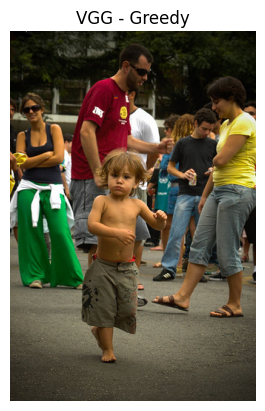


---------------------Actual---------------------
startseq a boy without a shirt is running in the street while several people stand behind him endseq
startseq a little boy dances with a group of people behind him on a city street endseq
startseq a small boy dances on the concrete surrounded by adults endseq
startseq the little boy wearing no shirt is running by a crowd of people endseq
startseq the shirtless little boy is walking around adults endseq
--------------------Predicted--------------------
startseq a girl in a pink shirt is running through a field endseq


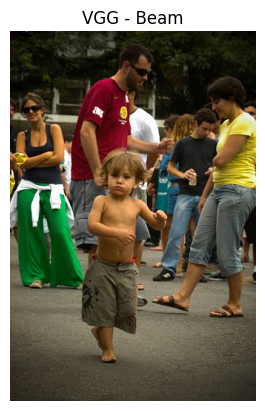


---------------------Actual---------------------
startseq a boy without a shirt is running in the street while several people stand behind him endseq
startseq a little boy dances with a group of people behind him on a city street endseq
startseq a small boy dances on the concrete surrounded by adults endseq
startseq the little boy wearing no shirt is running by a crowd of people endseq
startseq the shirtless little boy is walking around adults endseq
--------------------Predicted--------------------
startseq a group of young boys in green shirts and green shirts are walking down a street endseq


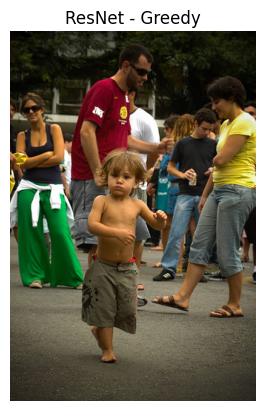


---------------------Actual---------------------
startseq a boy without a shirt is running in the street while several people stand behind him endseq
startseq a little boy dances with a group of people behind him on a city street endseq
startseq a small boy dances on the concrete surrounded by adults endseq
startseq the little boy wearing no shirt is running by a crowd of people endseq
startseq the shirtless little boy is walking around adults endseq
--------------------Predicted--------------------
startseq a group of young boys in green <unk> endseq


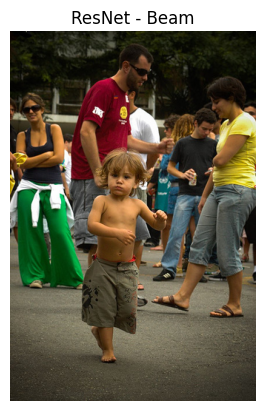

In [37]:
# Select a random image ID from the test set for qualitative evaluation
sample_img_id = random.choice(list(test_captions.keys()))

# Generate and display captions using VGG16 + LSTM with greedy decoding
show_actual_vs_predicted(sample_img_id, image_dir, word2idx, idx2word, model_type="VGG", beam=False)

# Generate and display captions using VGG16 + LSTM with beam search decoding
show_actual_vs_predicted(sample_img_id, image_dir, word2idx, idx2word, model_type="VGG", beam=True)

# Generate and display captions using ResNet + Attention + LSTM with greedy decoding
show_actual_vs_predicted(sample_img_id, image_dir, word2idx, idx2word, model_type="ResNet", beam=False)

# Generate and display captions using ResNet + Attention + LSTM with beam search decoding
show_actual_vs_predicted(sample_img_id, image_dir, word2idx, idx2word, model_type="ResNet", beam=True)

### 8.5 Qualitative Comparison on Multiple Images




===================== Image ID: 3670907052_c827593564 =====================

---------------------Actual---------------------
startseq a bmx rider in a red and black outfit is jumping on his motorcycle endseq
startseq a dirt biker flies through the air endseq
startseq a guy in red on a bike in midair endseq
startseq a man in a red outfit jumps his motocross bike down the hill endseq
startseq someone in red on a bike is moving in midair endseq
--------------------Predicted--------------------
startseq a person on a bike is jumping over a hill endseq


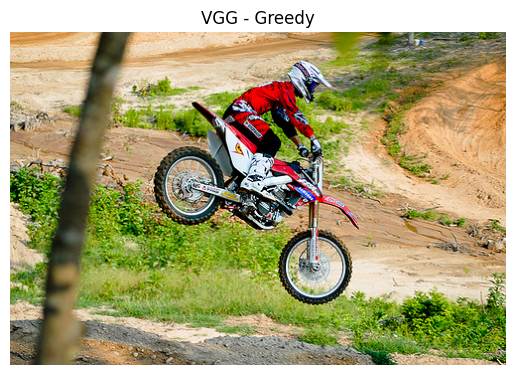


---------------------Actual---------------------
startseq a bmx rider in a red and black outfit is jumping on his motorcycle endseq
startseq a dirt biker flies through the air endseq
startseq a guy in red on a bike in midair endseq
startseq a man in a red outfit jumps his motocross bike down the hill endseq
startseq someone in red on a bike is moving in midair endseq
--------------------Predicted--------------------
startseq a person on a bike is jumping off a ramp endseq


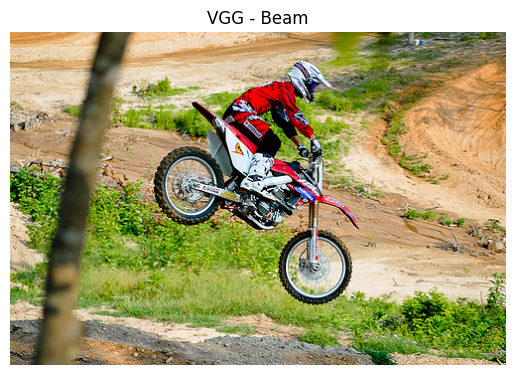


---------------------Actual---------------------
startseq a bmx rider in a red and black outfit is jumping on his motorcycle endseq
startseq a dirt biker flies through the air endseq
startseq a guy in red on a bike in midair endseq
startseq a man in a red outfit jumps his motocross bike down the hill endseq
startseq someone in red on a bike is moving in midair endseq
--------------------Predicted--------------------
startseq a person on a dirt bike is riding on a dirt track endseq


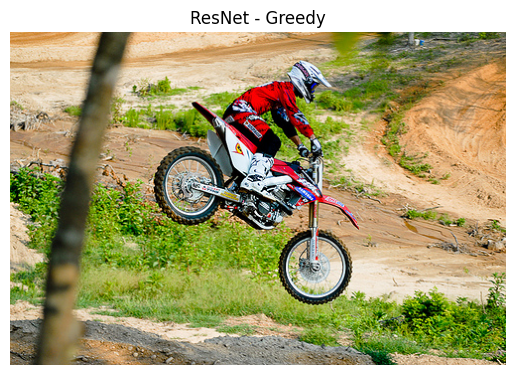


---------------------Actual---------------------
startseq a bmx rider in a red and black outfit is jumping on his motorcycle endseq
startseq a dirt biker flies through the air endseq
startseq a guy in red on a bike in midair endseq
startseq a man in a red outfit jumps his motocross bike down the hill endseq
startseq someone in red on a bike is moving in midair endseq
--------------------Predicted--------------------
startseq a dirt biker is riding a dirt bike endseq


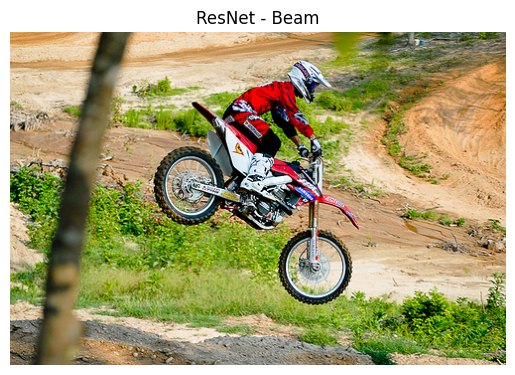


===================== Image ID: 315880837_90db309bab =====================

---------------------Actual---------------------
startseq three dogs are playing in the white snow endseq
startseq three dogs one holding a red frisbee standing in snow endseq
startseq three dogs playing with a frisbee in the snow endseq
startseq three dogs playing with a toy in the snow endseq
startseq three dogs play with a frisbee in a snowy field endseq
--------------------Predicted--------------------
startseq three dogs run around a track endseq


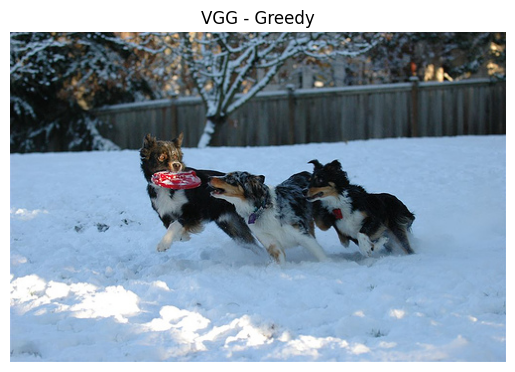


---------------------Actual---------------------
startseq three dogs are playing in the white snow endseq
startseq three dogs one holding a red frisbee standing in snow endseq
startseq three dogs playing with a frisbee in the snow endseq
startseq three dogs playing with a toy in the snow endseq
startseq three dogs play with a frisbee in a snowy field endseq
--------------------Predicted--------------------
startseq two dogs run through the snow endseq


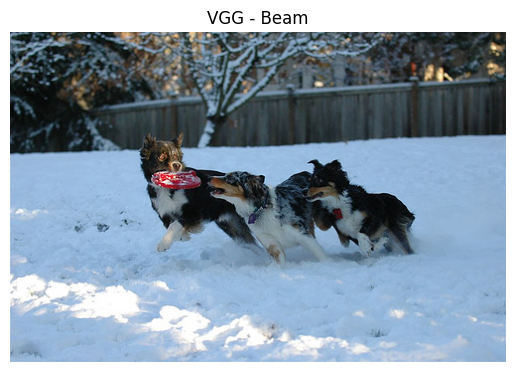


---------------------Actual---------------------
startseq three dogs are playing in the white snow endseq
startseq three dogs one holding a red frisbee standing in snow endseq
startseq three dogs playing with a frisbee in the snow endseq
startseq three dogs playing with a toy in the snow endseq
startseq three dogs play with a frisbee in a snowy field endseq
--------------------Predicted--------------------
startseq two dogs are running in the snow endseq


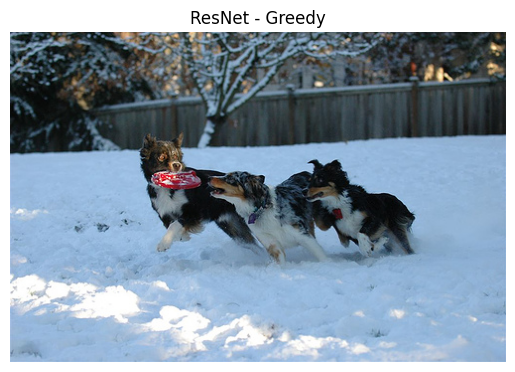


---------------------Actual---------------------
startseq three dogs are playing in the white snow endseq
startseq three dogs one holding a red frisbee standing in snow endseq
startseq three dogs playing with a frisbee in the snow endseq
startseq three dogs playing with a toy in the snow endseq
startseq three dogs play with a frisbee in a snowy field endseq
--------------------Predicted--------------------
startseq two dogs are playing in the snow endseq


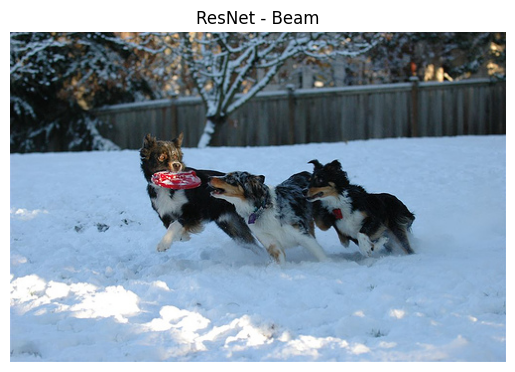


===================== Image ID: 3635577874_48ebaac734 =====================

---------------------Actual---------------------
startseq a man rides his blue bike high in the air over a park endseq
startseq a man wearing blue and riding a blue bike jumping in midair endseq
startseq someone is airborne on a turquoise bicycle endseq
startseq the boy is doing a stunt through the air on his bicycle endseq
startseq the man is performing a trick high in the air with a bicycle endseq
--------------------Predicted--------------------
startseq a person on a bike is jumping over a ramp endseq


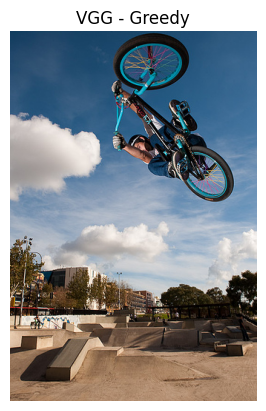


---------------------Actual---------------------
startseq a man rides his blue bike high in the air over a park endseq
startseq a man wearing blue and riding a blue bike jumping in midair endseq
startseq someone is airborne on a turquoise bicycle endseq
startseq the boy is doing a stunt through the air on his bicycle endseq
startseq the man is performing a trick high in the air with a bicycle endseq
--------------------Predicted--------------------
startseq a person rides a bike down a hill endseq


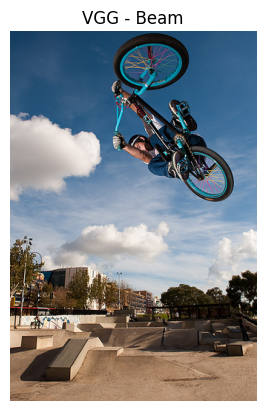


---------------------Actual---------------------
startseq a man rides his blue bike high in the air over a park endseq
startseq a man wearing blue and riding a blue bike jumping in midair endseq
startseq someone is airborne on a turquoise bicycle endseq
startseq the boy is doing a stunt through the air on his bicycle endseq
startseq the man is performing a trick high in the air with a bicycle endseq
--------------------Predicted--------------------
startseq a bmx biker is jumping over a jump endseq


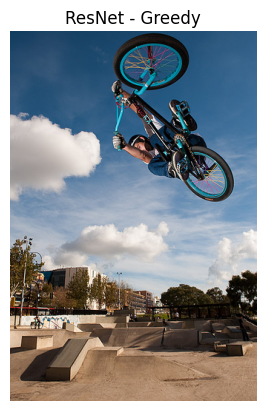


---------------------Actual---------------------
startseq a man rides his blue bike high in the air over a park endseq
startseq a man wearing blue and riding a blue bike jumping in midair endseq
startseq someone is airborne on a turquoise bicycle endseq
startseq the boy is doing a stunt through the air on his bicycle endseq
startseq the man is performing a trick high in the air with a bicycle endseq
--------------------Predicted--------------------
startseq a bmx biker is jumping over a jump endseq


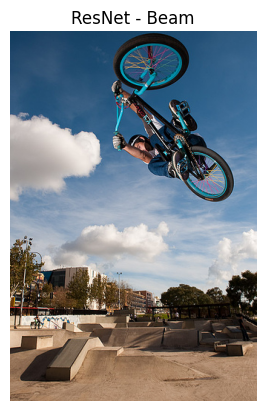

In [38]:
# Select 3 random image IDs from the test set
sample_img_ids = random.sample(list(test_captions.keys()), 3)

# Loop through each selected image and display actual vs predicted captions
# - Shows both Greedy and Beam Search outputs
# - Compares outputs from VGG16 + LSTM and ResNet + Attention + LSTM
# - Helps visualize differences across models and decoding strategies
for img_id in sample_img_ids:
    print(f"\n===================== Image ID: {img_id} =====================")

    # VGG16 + LSTM - Greedy Decoding
    show_actual_vs_predicted(img_id, image_dir, word2idx, idx2word, model_type="VGG", beam=False)

    # VGG16 + LSTM - Beam Search Decoding
    show_actual_vs_predicted(img_id, image_dir, word2idx, idx2word, model_type="VGG", beam=True)

    # ResNet + Attention + LSTM - Greedy Decoding
    show_actual_vs_predicted(img_id, image_dir, word2idx, idx2word, model_type="ResNet", beam=False)

    # ResNet + Attention + LSTM - Beam Search Decoding
    show_actual_vs_predicted(img_id, image_dir, word2idx, idx2word, model_type="ResNet", beam=True)